# Dropout
Dropout[1]是一种神经网络正则化的技术，它通过在前向传递中将一些特征随机设置为0来实现。在这个练习中，您将实现一个dropout层，并修改您的全连接网络，以选择使用dropout。

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [ ]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
在文件`cs231n/layers.py`，为dropout执行向前传递。由于dropout在训练和测试期间的行为不同，请确保实现两种模式的操作。
完成之后，运行下面的单元以测试您的实现。

In [3]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.3
Mean of input:  10.000207878477502
Mean of train-time output:  10.035072797050494
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.699124
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.000207878477502
Mean of train-time output:  9.976910758765856
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.401368
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.000207878477502
Mean of train-time output:  9.993068588261146
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.250496
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
在文件`cs231n/layers.py`，实现dropout的向后传递。这样做之后，运行以下单元格来进行数值梯度检查。

In [4]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.8928964971078328e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

那么我们就需要在测试阶段让结果乘以p，换句话说，就不是inverted Dropout了，因为不除以p会导致输出的期望发生改变，一般来说，我们不想让使用了Dropout的网络在测试阶段和正常网络有所不同。

# Fully-connected nets with Dropout
在文件`cs231n/classifiers/fc_net`中。修改您的实现以使用dropout。从表面上看，如果网络的构造函数为“dropout”参数接收到一个非零值，那么网络应该在每个ReLU非线性之后立即添加dropout。这样做之后，运行下面的代码来对实现进行数值梯度检查。

In [5]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5, 0.75, 1]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)
  loss, grads = model.loss(X, y)
  
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.25
Initial loss:  2.2924325088330475
W1 relative error: 2.74e-08
W2 relative error: 2.98e-09
W3 relative error: 4.29e-09
b1 relative error: 7.78e-10
b2 relative error: 3.36e-10
b3 relative error: 1.65e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10

Running check with dropout =  0.75
Initial loss:  2.302848733153321
W1 relative error: 7.87e-07
W2 relative error: 1.45e-07
W3 relative error: 1.70e-07
b1 relative error: 1.83e-08
b2 relative error: 2.81e-09
b3 relative error: 1.49e-10

Running check with dropout =  1
Initial loss:  2.3048

# 正则化实验
作为一个实验，我们将在500个训练示例上训练网络,然后，我们将在一段时间内可视化这几个网络的训练和验证准确性。

In [24]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 200
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.2]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 50) loss: 6.619109
(Epoch 0 / 25) train acc: 0.250000; val_acc: 0.134000
(Epoch 1 / 25) train acc: 0.295000; val_acc: 0.188000
(Epoch 2 / 25) train acc: 0.350000; val_acc: 0.172000
(Epoch 3 / 25) train acc: 0.355000; val_acc: 0.159000
(Epoch 4 / 25) train acc: 0.475000; val_acc: 0.211000
(Epoch 5 / 25) train acc: 0.565000; val_acc: 0.255000
(Epoch 6 / 25) train acc: 0.580000; val_acc: 0.213000
(Epoch 7 / 25) train acc: 0.585000; val_acc: 0.175000
(Epoch 8 / 25) train acc: 0.640000; val_acc: 0.185000
(Epoch 9 / 25) train acc: 0.720000; val_acc: 0.219000
(Epoch 10 / 25) train acc: 0.690000; val_acc: 0.223000
(Epoch 11 / 25) train acc: 0.790000; val_acc: 0.245000
(Epoch 12 / 25) train acc: 0.845000; val_acc: 0.250000
(Epoch 13 / 25) train acc: 0.850000; val_acc: 0.220000
(Epoch 14 / 25) train acc: 0.865000; val_acc: 0.185000
(Epoch 15 / 25) train acc: 0.870000; val_acc: 0.207000
(Epoch 16 / 25) train acc: 0.935000; val_acc: 0.219000
(Epoch 17 / 25) train acc: 0.920000; val_

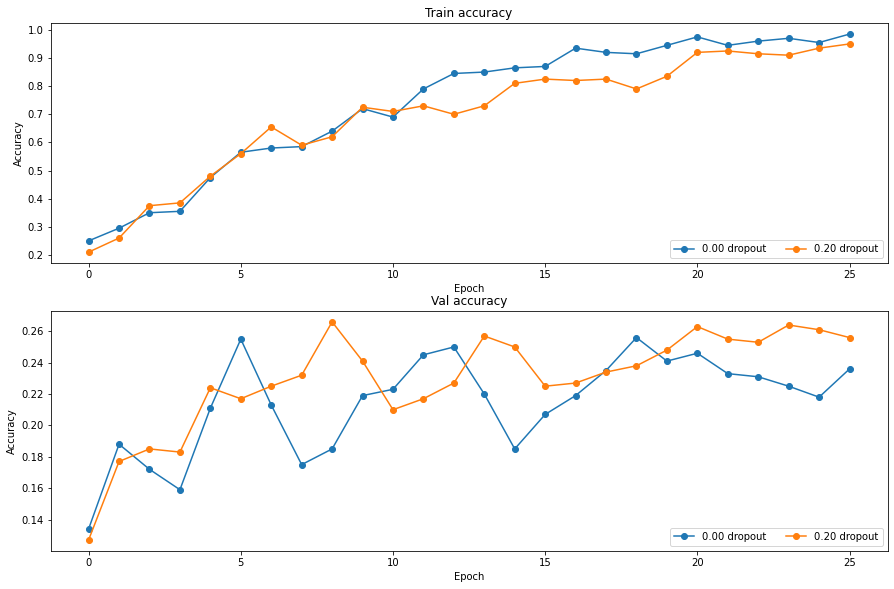

In [25]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, '-o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, '-o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:

这表明了Dropout对于抑制过拟合有比较好的效果，在图中可以看到虽然使用了Dropout的网络在训练集的精度稍微下降，但是在验证集上取得了比较好的效果。

# Answer
在一定程度上抑制了过拟合